## Model

In [2]:
# !pip install imagecodecs

In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib, matplotlib.pyplot as plt
from PIL import Image 
from skimage import io
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import random


if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
def setup_seed(seed): 
    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed) 
    np.random.seed(seed) 
    random.seed(seed) 
    torch.backends.cudnn.deterministic = True
    return None
setup_seed(0)

In [9]:
train_df = pd.read_csv('DBT_train_resized_tiff.csv')
train_df.head()

,Unnamed: 0,PatientID,StudyUID,Label,View,descriptive_path,classic_path,new_path
0,0,DBT-P01013,DBT-S00665,0,lcc,tiff_Breast-Cancer-Screening-DBT/DBT-P01013/01...,Breast-Cancer-Screening-DBT/DBT-P01013/1.2.826...,tiff_Breast-Cancer-Screening-DBT/DBT-P01013/01...
1,1,DBT-P01013,DBT-S00665,0,lmlo,tiff_Breast-Cancer-Screening-DBT/DBT-P01013/01...,Breast-Cancer-Screening-DBT/DBT-P01013/1.2.826...,tiff_Breast-Cancer-Screening-DBT/DBT-P01013/01...
2,2,DBT-P01013,DBT-S00665,0,rcc,tiff_Breast-Cancer-Screening-DBT/DBT-P01013/01...,Breast-Cancer-Screening-DBT/DBT-P01013/1.2.826...,tiff_Breast-Cancer-Screening-DBT/DBT-P01013/01...
3,3,DBT-P01013,DBT-S00665,0,rmlo,tiff_Breast-Cancer-Screening-DBT/DBT-P01013/01...,Breast-Cancer-Screening-DBT/DBT-P01013/1.2.826...,tiff_Breast-Cancer-Screening-DBT/DBT-P01013/01...
4,4,DBT-P04493,DBT-S02147,0,lcc,tiff_Breast-Cancer-Screening-DBT/DBT-P04493/01...,Breast-Cancer-Screening-DBT/DBT-P04493/1.2.826...,tiff_Breast-Cancer-Screening-DBT/DBT-P04493/01...


In [10]:
val_df = pd.read_csv('DBT_val_resized_tiff.csv')
val_df.head()

,Unnamed: 0,PatientID,StudyUID,Label,View,descriptive_path,classic_path,new_path
0,0,DBT-P02642,DBT-S01298,0,lcc,tiff_Breast-Cancer-Screening-DBT/DBT-P02642/01...,Breast-Cancer-Screening-DBT/DBT-P02642/1.2.826...,tiff_Breast-Cancer-Screening-DBT/DBT-P02642/01...
1,1,DBT-P02642,DBT-S01298,0,lmlo,tiff_Breast-Cancer-Screening-DBT/DBT-P02642/01...,Breast-Cancer-Screening-DBT/DBT-P02642/1.2.826...,tiff_Breast-Cancer-Screening-DBT/DBT-P02642/01...
2,2,DBT-P02642,DBT-S01298,0,rcc,tiff_Breast-Cancer-Screening-DBT/DBT-P02642/01...,Breast-Cancer-Screening-DBT/DBT-P02642/1.2.826...,tiff_Breast-Cancer-Screening-DBT/DBT-P02642/01...
3,3,DBT-P02642,DBT-S01298,0,rmlo,tiff_Breast-Cancer-Screening-DBT/DBT-P02642/01...,Breast-Cancer-Screening-DBT/DBT-P02642/1.2.826...,tiff_Breast-Cancer-Screening-DBT/DBT-P02642/01...
4,4,DBT-P03849,DBT-S00732,0,lcc,tiff_Breast-Cancer-Screening-DBT/DBT-P03849/01...,Breast-Cancer-Screening-DBT/DBT-P03849/1.2.826...,tiff_Breast-Cancer-Screening-DBT/DBT-P03849/01...


In [11]:
print('Number of biopsied samples:', np.sum(train_df['Label'].values))
print('Number of normal samples:', len(train_df) - np.sum(train_df['Label'].values))
disease_ratio = np.sum(train_df['Label'].values) / len(train_df)
print('Disease Ratio:', disease_ratio)

Number of biopsied samples: 500
Number of normal samples: 12760
Disease Ratio: 0.03770739064856712


### Data Loader

In [12]:
train_transform = transforms.Compose([])
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(transforms.Resize((224,224)))

test_transform = transforms.Compose([])
test_transform.transforms.append(transforms.ToTensor())
test_transform.transforms.append(transforms.Resize((224,224)))

class DBT_Dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_name = self.df.iloc[idx, -1]
        image = io.imread(image_name,as_gray=True)
        image = image.astype(float)
        
        # Normalization
        image -= np.mean(image)
        image /= np.maximum(np.std(image), 10**(-5))
        
        if self.train:
            image_tensor = train_transform(image)
        else:
            image_tensor = test_transform(image)
            
       
        label = self.df['Label'].iloc[idx]
        label = torch.tensor(label, dtype=torch.long)
        sample = {'x': image_tensor.float(),'y': label}

        return sample

In [18]:
# Set up WeightedRandomSampler
labels = np.array(train_df['Label'])
labels = labels.astype(int)
majority_weight = len(train_df) - np.sum(train_df['Label'].values)
minority_weight = np.sum(train_df['Label'].values)
sample_weights = np.array([majority_weight, minority_weight])
weights = sample_weights[labels]
sampler = WeightedRandomSampler(weights=weights, num_samples=100, replacement=True)

In [19]:
train_df_path = 'DBT_train_resized_tiff.csv'
val_df_path = 'DBT_val_resized_tiff.csv'
test_df_path = 'DBT_test_resized_tiff.csv'
bs = 16

# train_loader = DataLoader(DBT_Dataset(train_df_path,train = True), batch_size=bs, \
#                           shuffle=True, num_workers=8, pin_memory=True)
train_loader = DataLoader(DBT_Dataset(train_df_path,train = True), batch_size=bs, \
                          num_workers=8, pin_memory=True, sampler=sampler)
val_loader = DataLoader(DBT_Dataset(val_df_path), batch_size=bs, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(DBT_Dataset(test_df_path), batch_size=bs, shuffle=False, num_workers=8, pin_memory=True)

/ext3/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/ext3/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/ext3/miniconda3/lib/python3.9/site-pack

### Training

In [20]:
def train_fun(model, train_loader=train_loader, val_loader=val_loader, learning_rate=1e-5, \
              num_epoch=100, save_name='model'):
    start_time = time.time()
    
    optimizer = optim.Adam(model.parameters(),lr=learning_rate, weight_decay=1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epoch)
    

    distribution = torch.FloatTensor([1-disease_ratio, disease_ratio]).to(device)
#     loss_fn = nn.CrossEntropyLoss(weight=distribution)
    loss_fn = nn.CrossEntropyLoss()
    
    train_loss_return = []
    train_acc_return = []
    val_loss_return = []
    val_acc_return = []
    
    best_acc = -1
    
    # Train
    for epoch in range(num_epoch):
        pred_list = []
        pred_scores_list = []
        truths_list = []
        loss_list = []
        model.train()
        for i, (sample) in enumerate(train_loader):
            image = sample['x'].to(device)
            labels = sample['y'].to(device)    
            outputs = model(image)
            model.zero_grad()
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_list.append(loss.item())
            pred_score = nn.Softmax(1)(outputs).cpu().detach().numpy()
            pred_scores_list += pred_score.tolist()
            pred  = np.argmax(pred_score,axis=1)
            pred_list += pred.tolist()
            truths_list += labels.cpu().numpy().tolist()
        scheduler.step()
        # report performance
        correct_num = (np.array(pred_list) == np.array(truths_list)).sum()
        acc = correct_num/len(truths_list)
        train_acc_return.append(acc)
        train_loss_return.append(np.average(loss_list))
        print('----------Epoch{:2d}/{:2d}----------'.format(epoch+1,num_epoch))
        print('Train set | Loss: {:6.4f} | Accuracy: {:4.2f}% '\
              .format(np.average(loss_list), acc*100))
        
        # Val
        pred_list = []
        pred_scores_list = []
        truths_list = []
        loss_list = []
        model.eval()
        with torch.no_grad():
            for i, (sample) in enumerate(val_loader):
                image = sample['x'].to(device)
                labels = sample['y'].to(device)  
                outputs = model(image)
                loss = loss_fn(outputs, labels)
                loss_list.append(loss.item())
                pred_score = nn.Softmax(1)(outputs).cpu().detach().numpy()
                pred_scores_list += pred_score.tolist()
                pred  = np.argmax(pred_score,axis=1)
                pred_list += pred.tolist()
                truths_list += labels.cpu().numpy().tolist()
            # report performance
            correct_num = (np.array(pred_list) == np.array(truths_list)).sum()
            acc = correct_num/len(truths_list)
            val_acc_return.append(acc)
            val_loss_return.append(np.average(loss_list))
            if acc > best_acc:
                best_acc = acc
                best_model_wts = model.state_dict()
            elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
            print('Val set  | Loss: {:6.4f} | Accuracy: {:4.2f}% | Best ACC: {:6.4f} | time elapse: {:>9}'\
                  .format(np.average(loss_list), acc*100, best_acc*100, elapse))
            save_model(model, best_model_wts, train_loss_return, train_acc_return,\
                       val_loss_return, val_acc_return, save_name=save_name)
            
    return None

def save_model(model, best_model_wts, train_loss_return,train_acc_return,\
               val_loss_return, val_acc_return, save_name):
    state = {'best_model_wts':best_model_wts, 'model':model, \
             'train_loss':train_loss_return, 'train_acc':train_acc_return,\
             'val_loss':val_loss_return, 'val_acc':val_acc_return}
    torch.save(state, save_name+'.pt')
    return None

### Data Augmentation

In [23]:
train_transform = transforms.Compose([])
train_transform.transforms.append(transforms.ToTensor())
transforms.RandomRotation(20, expand=True)
train_transform.transforms.append(transforms.RandomResizedCrop(224, scale=(0.8, 1.2), ratio=(1.0,1.0)))
train_transform.transforms.append(transforms.RandomErasing())
train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.ColorJitter(hue=0.5, saturation=0.5, contrast=0.5))


test_transform = transforms.Compose([])
test_transform.transforms.append(transforms.ToTensor())
test_transform.transforms.append(transforms.Resize((224,224)))

class DBT_Dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_name = self.df.iloc[idx, -1]
        image = io.imread(image_name,as_gray=True)
        image = image.astype(float)
        
        # Normalization
        image -= np.mean(image)
        image /= np.maximum(np.std(image), 10**(-5))
        
        if self.train:
            image_tensor = train_transform(image)
        else:
            image_tensor = test_transform(image)
            
       
        label = self.df['Label'].iloc[idx]
        label = torch.tensor(label, dtype=torch.long)
        sample = {'x': image_tensor.float(),'y': label}

        return sample

In [25]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=2, bias=True)
setup_seed(0)
model = model.to(device)
train_fun(model, num_epoch=6, save_name='model_2')

Using cache found in /home/em4449/.cache/torch/hub/pytorch_vision_v0.10.0


----------Epoch 1/ 6----------
Train set | Loss: 0.9039 | Accuracy: 23.00% 
Val set  | Loss: 0.8010 | Accuracy: 26.74% | Best ACC: 26.7405 | time elapse:  00:00:15
----------Epoch 2/ 6----------
Train set | Loss: 0.8673 | Accuracy: 27.00% 
Val set  | Loss: 0.8316 | Accuracy: 25.37% | Best ACC: 26.7405 | time elapse:  00:00:25
----------Epoch 3/ 6----------
Train set | Loss: 0.8430 | Accuracy: 40.00% 
Val set  | Loss: 0.8387 | Accuracy: 27.43% | Best ACC: 27.4262 | time elapse:  00:00:35
----------Epoch 4/ 6----------
Train set | Loss: 0.8167 | Accuracy: 40.00% 
Val set  | Loss: 0.8180 | Accuracy: 31.33% | Best ACC: 31.3291 | time elapse:  00:00:45
----------Epoch 5/ 6----------
Train set | Loss: 0.7975 | Accuracy: 40.00% 
Val set  | Loss: 0.6462 | Accuracy: 63.45% | Best ACC: 63.4494 | time elapse:  00:00:55
----------Epoch 6/ 6----------
Train set | Loss: 0.7960 | Accuracy: 43.00% 
Val set  | Loss: 0.4764 | Accuracy: 89.03% | Best ACC: 89.0295 | time elapse:  00:01:05


### Model Evaluation

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [27]:
# load best weights
path = 'model_2.pt'
model.load_state_dict(torch.load(path)['best_model_wts'])

<All keys matched successfully>

In [28]:
test_loader = DataLoader(DBT_Dataset(test_df_path), batch_size=bs, shuffle=False, num_workers=8, pin_memory=True)

/ext3/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [29]:
def evaluate_model(model, test_loader):
    pred_list = []
    pred_scores_list = []
    truths_list = []
    
    model.eval()
    with torch.no_grad():
        for i, (sample) in enumerate(test_loader):
            image = sample['x'].to(device)
            labels = sample['y'].to(device)          # sample['y'].squeeze(1).to(device)
            outputs = model(image)
            pred_score = nn.Softmax(1)(outputs).cpu().detach().numpy()
            pred_scores_list += pred_score.tolist()
            pred  = np.argmax(pred_score,axis=1)
            pred_list += pred.tolist()
            truths_list += labels.cpu().numpy().tolist()
    return np.array(pred_list), np.array(pred_scores_list), np.array(truths_list)

In [30]:
pred, pred_scores, truths = evaluate_model(model, test_loader)

In [31]:
print('Prediction:',pred[:10])
print('Truth:     ',truths[:10])
print('Prediction Probability:\n',pred_scores[:10])

Prediction: [1 0 0 1 1 0 0 0 0 0]
Truth:      [0 0 0 0 0 0 0 0 0 0]
Prediction Probability:
 [[0.49764228 0.50235772]
 [0.7134499  0.2865501 ]
 [0.69013309 0.30986694]
 [0.49622786 0.50377214]
 [0.48827964 0.51172036]
 [0.6248523  0.3751477 ]
 [0.68458956 0.31541044]
 [0.67312908 0.32687089]
 [0.61247587 0.38752413]
 [0.70123196 0.29876798]]


In [32]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def ROC_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['aqua', 'darkorange'])
    lw = 2
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    return None

In [33]:
truth_is_0 = (truths == 0).astype(int)
truth_is_1 = (truths == 1).astype(int)
y_test = np.array([truth_is_0, truth_is_1])
y_test = np.transpose(y_test,(1,0))
print('Truth = 0:',truth_is_0[:10])
print('Truth = 1:',truth_is_1[:10])
print('Label for ROC:')
print(y_test[:,:10])
print('Prediction Probability for ROC:')
print(pred_scores[:,:10])

Truth = 0: [1 1 1 1 1 1 1 1 1 1]
Truth = 1: [0 0 0 0 0 0 0 0 0 0]
Label for ROC:
[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]
Prediction Probability for ROC:
[[0.49764228 0.50235772]
 [0.7134499  0.2865501 ]
 [0.69013309 0.30986694]
 ...
 [0.66933888 0.33066115]
 [0.6943292  0.30567083]
 [0.66800386 0.33199614]]


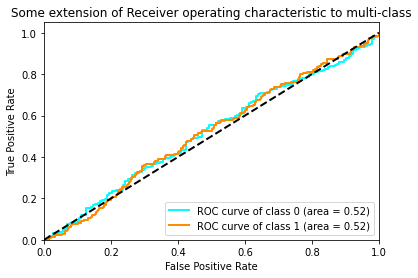

In [34]:
ROC_curve(y_test,pred_scores)

In [35]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)
    #print(cm.shape)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return None


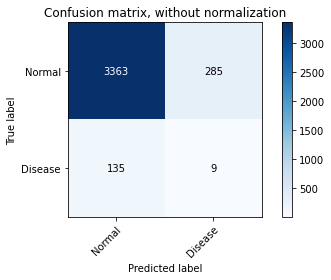

In [36]:
classes = ['Normal','Disease']
plot_confusion_matrix(truths, pred, classes)